In [65]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [66]:
df = pd.read_csv('data_cleaned.csv')

In [67]:
df = df.drop(df.columns[0], axis =1)

In [68]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,lat,long,postal_code,price_sqft,grade_code,condition_code
0,2310000170,750000.0,3,2.0,1590,7754,1.0,440,0,1990,47.357065,-122.04067,98038,471.698113,7,4
1,2095600170,580000.0,3,3.0,2020,4482,1.0,600,120,1992,47.399470,-122.20413,98031,287.128713,7,3
2,8682282030,2000000.0,3,3.0,2700,7694,1.0,530,640,2006,47.708760,-122.02073,98053,740.740741,9,3
3,5727500011,785000.0,3,2.0,1350,7354,1.0,460,120,1985,47.751020,-122.33447,98133,581.481481,7,5
4,1421059003,1680000.0,3,2.5,5200,206039,1.0,1080,670,2007,47.310595,-122.12938,98092,323.076923,10,3


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2739 non-null   int64  
 1   price           2739 non-null   float64
 2   bedrooms        2739 non-null   int64  
 3   bathrooms       2739 non-null   float64
 4   sqft_living     2739 non-null   int64  
 5   sqft_lot        2739 non-null   int64  
 6   floors          2739 non-null   float64
 7   sqft_garage     2739 non-null   int64  
 8   sqft_patio      2739 non-null   int64  
 9   yr_built        2739 non-null   int64  
 10  lat             2739 non-null   float64
 11  long            2739 non-null   float64
 12  postal_code     2739 non-null   int64  
 13  price_sqft      2739 non-null   float64
 14  grade_code      2739 non-null   int64  
 15  condition_code  2739 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 342.5 KB


In [70]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,lat,long,postal_code,price_sqft,grade_code,condition_code
0,2310000170,750000.0,3,2.0,1590,7754,1.0,440,0,1990,47.357065,-122.04067,98038,471.698113,7,4
1,2095600170,580000.0,3,3.0,2020,4482,1.0,600,120,1992,47.399470,-122.20413,98031,287.128713,7,3
2,8682282030,2000000.0,3,3.0,2700,7694,1.0,530,640,2006,47.708760,-122.02073,98053,740.740741,9,3
3,5727500011,785000.0,3,2.0,1350,7354,1.0,460,120,1985,47.751020,-122.33447,98133,581.481481,7,5
4,1421059003,1680000.0,3,2.5,5200,206039,1.0,1080,670,2007,47.310595,-122.12938,98092,323.076923,10,3


In [90]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,lat,long,postal_code,price_sqft,grade_code,condition_code
id,1.000000,-0.004950,-0.081485,-0.061117,-0.062404,-0.194356,NaN,-0.033761,-0.066157,0.038581,0.023895,-0.002979,-0.021484,0.041943,0.010026,-0.004090
price,-0.004950,1.000000,0.175557,0.354974,0.544085,0.174859,NaN,0.219676,0.272825,0.094256,0.529505,0.157289,0.004348,0.670047,0.563026,0.031057
bedrooms,-0.081485,0.175557,1.000000,0.554087,0.508276,0.011878,NaN,0.097588,0.103816,-0.103614,0.011607,-0.177033,0.099168,-0.227708,0.159034,0.092302
bathrooms,-0.061117,0.354974,0.554087,1.000000,0.649924,0.052641,NaN,0.242000,0.231143,0.045655,0.117657,-0.126706,0.078576,-0.150695,0.393339,0.044564
sqft_living,-0.062404,0.544085,0.508276,0.649924,1.000000,0.229486,NaN,0.300503,0.392119,0.067473,0.121611,-0.023105,0.023923,-0.198393,0.633475,0.006310
sqft_lot,-0.194356,0.174859,0.011878,0.052641,0.229486,1.000000,NaN,0.053387,0.177479,0.079393,-0.037049,0.202047,-0.049347,0.020097,0.147383,-0.021945
floors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_garage,-0.033761,0.219676,0.097588,0.242000,0.300503,0.053387,NaN,1.000000,0.141184,0.035891,-0.008482,0.085876,-0.074445,-0.009491,0.381393,-0.032730
sqft_patio,-0.066157,0.272825,0.103816,0.231143,0.392119,0.177479,NaN,0.141184,1.000000,-0.038489,0.045840,0.043742,-0.013179,-0.006084,0.275381,0.081639
yr_built,0.038581,0.094256,-0.103614,0.045655,0.067473,0.079393,NaN,0.035891,-0.038489,1.000000,-0.021220,0.144561,0.024194,0.048332,0.153222,-0.317267


In [91]:
X = df.drop(columns = ['price', 'floors'])
y = df['price']

In [92]:
X.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_garage,sqft_patio,yr_built,lat,long,postal_code,price_sqft,grade_code,condition_code
0,2310000170,3,2.0,1590,7754,440,0,1990,47.357065,-122.04067,98038,471.698113,7,4
1,2095600170,3,3.0,2020,4482,600,120,1992,47.399470,-122.20413,98031,287.128713,7,3
2,8682282030,3,3.0,2700,7694,530,640,2006,47.708760,-122.02073,98053,740.740741,9,3
3,5727500011,3,2.0,1350,7354,460,120,1985,47.751020,-122.33447,98133,581.481481,7,5
4,1421059003,3,2.5,5200,206039,1080,670,2007,47.310595,-122.12938,98092,323.076923,10,3


In [101]:
X.grade_code.value_counts()

7     1456
8      932
9      175
6      114
10      53
11       5
5        2
12       2
Name: grade_code, dtype: int64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1337)

dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_train)
dummy_regr.predict(X_test)
dummy_regr.score(X_train, y_train)
dummy_regr.score(X_test, y_test)
dummy_train_RMSE = MSE(y_train,dummy_regr.predict(X_train), squared = False)
dummy_test_RMSE = MSE(y_test,dummy_regr.predict(X_test), squared = False)

print()
print(f'Baseline Model Train Score: {dummy_regr.score(X_train, y_train)}')
print(f'Baseline Model Train RMSE: {round(dummy_train_RMSE)}')
print()
print(f'Baseline Model Test Score: {dummy_regr.score(X_test, y_test)}')
print(f'Baseline Model Test RMSE: {round(dummy_test_RMSE)}')


Baseline Model Train Score: 0.0
Baseline Model Train RMSE: 382686.0

Baseline Model Test Score: -0.0006037036759904968
Baseline Model Test RMSE: 394626.0


In [94]:
most_correlated_feature = 'sqft_living'

In [95]:
from sklearn.linear_model import LinearRegression

base_model = LinearRegression()

In [96]:
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=1337)

base_scores = cross_validate(
    estimator=base_model,
    X=X_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", base_scores["train_score"].mean())
print("Validation score:", base_scores["test_score"].mean())

Train score:      0.3049586211218845
Validation score: 0.2700790498744639


In [97]:
X_train_simple_model = X_train[['sqft_living']]
X_test_simple_model = X_test[['sqft_living']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=1337)

simple_model = LinearRegression()
simple_model.fit(X_train_simple_model,y_train)

simple_model_scores = cross_validate(estimator=simple_model, X=df[['sqft_living']], y=df.price, return_train_score=True, cv=splitter)

simple_predict_train = simple_model.predict(X_train_simple_model)
simple_predict_test = simple_model.predict(X_test_simple_model)

simple_train_RMSE = MSE(y_train,simple_predict_train,squared = False)
simple_test_RMSE = MSE(y_test,simple_predict_test, squared = False)

simple_condition_num = sm.OLS(y_train, sm.add_constant(X_train_simple_model)).fit().condition_number

print(f'Simple Model Train score: {simple_model_scores["train_score"].mean()}')
print(f'Simple Model Train RMSE: {round(simple_train_RMSE)}')
print(f'Simple Model Train Condition Number: {simple_condition_num}')
print()
print("Simple Model Test score: ", simple_model_scores["test_score"].mean())
print(f'Simple Model Test RMSE: {round(simple_test_RMSE)}')

Simple Model Train score: 0.30002988402321956
Simple Model Train RMSE: 320280.0
Simple Model Train Condition Number: 6270.338908771662

Simple Model Test score:  0.28057822388128384
Simple Model Test RMSE: 332699.0


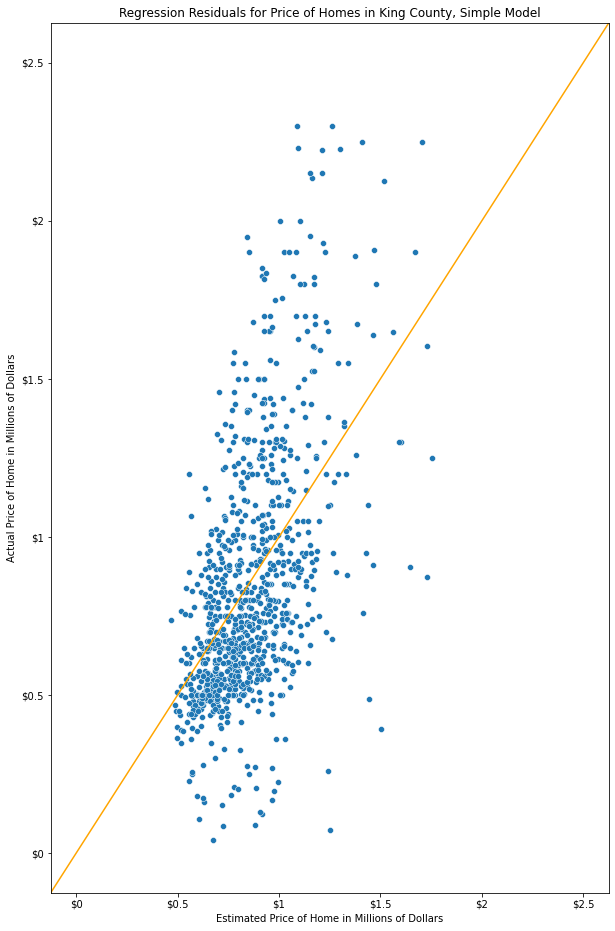

In [98]:
fig, ax = plt.subplots(figsize = (10,16))

sns.scatterplot(x = simple_predict_test, y = y_test, ax=ax)
ax.set_title('Regression Residuals for Price of Homes in King County, Simple Model')
ax.set_xlabel('Estimated Price of Home in Millions of Dollars')
ax.set_ylabel('Actual Price of Home in Millions of Dollars')
ax.ticklabel_format(style='plain') 
millions = ticker.FuncFormatter(lambda x, pos: '${0:g}'.format(x/1000000))
ax.yaxis.set_major_formatter(millions)
ax.xaxis.set_major_formatter(millions)
x,y = [range(0,2500000,500000)],[range(0,2500000,500000)]
plt.axline((0,0),(2500000,2500000), color = 'orange')
plt.show()